# Step4：建模调参

运用常用算法建模，模型的评价以及调参

## 4.1 能学到什么

## 4.2 流程

1、处理数据，基于算法建立模型

2、模型性能验证

3、特征选择

4、比较模型

5、调参

## 4.3 算法原理介绍

## 4.4 代码

### 4.4.1 读取数据

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

下边的函数，通过修改数据类型，降低数据在内存中占用的空间

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
sample_feature = reduce_mem_usage(pd.read_csv('data_for_tree.csv'))

Memory usage of dataframe is 62099672.00 MB
Memory usage after optimization is: 16520303.00 MB
Decreased by 73.4%


In [5]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model','brand']]

### 4.4.2 建模验证

In [6]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]

train_X = train[continuous_feature_names]
train_y = train['price']

1、建模

In [8]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)
model = model.fit(train_X, train_y)

输出线性回归模型的参数即：截距和参数

In [9]:
'intercept:'+ str(model.intercept_)

sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('v_6', 3367064.341641901),
 ('v_8', 700675.5609398846),
 ('v_9', 170630.27723221088),
 ('v_7', 32322.661932023715),
 ('v_12', 20473.670796966464),
 ('v_3', 17868.07954149422),
 ('v_11', 11474.938996741424),
 ('v_13', 11261.764560013271),
 ('v_10', 2683.920090556804),
 ('gearbox', 881.8225039247703),
 ('fuelType', 363.9042507216862),
 ('bodyType', 189.60271012075074),
 ('city', 44.9497512052223),
 ('power', 28.553901616752945),
 ('brand_price_median', 0.5103728134079206),
 ('brand_price_std', 0.4503634709263355),
 ('brand_amount', 0.14881120395065559),
 ('brand_price_max', 0.0031910186703134184),
 ('SaleID', 5.3559899198556306e-05),
 ('seller', 3.312714397907257e-06),
 ('offerType', 2.771965228021145e-06),
 ('train', 4.7206413000822067e-07),
 ('brand_price_sum', -2.175006868187581e-05),
 ('name', -0.00029800127130370817),
 ('used_time', -0.002515894332876499),
 ('brand_price_average', -0.40490484510118563),
 ('brand_price_min', -2.246775348689076),
 ('power_bin', -34.420644117268296),

In [10]:
from matplotlib import pyplot as plt

In [11]:
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

绘图可视化预测结果与标签

可以发现差异较大

The predicted price is obvious different from true price


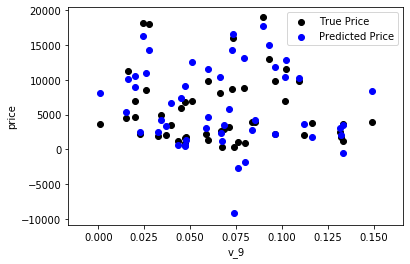

In [13]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

通过作图我们发现数据的标签（price）呈现长尾分布，不利于我们的建模预测。原因是很多模型都假设数据误差项符合正态分布，而长尾分布的数据违背了这一假设。参考博客：https://blog.csdn.net/Noob_daniel/article/details/76087829



It is clear to see the price shows a typical exponential distribution


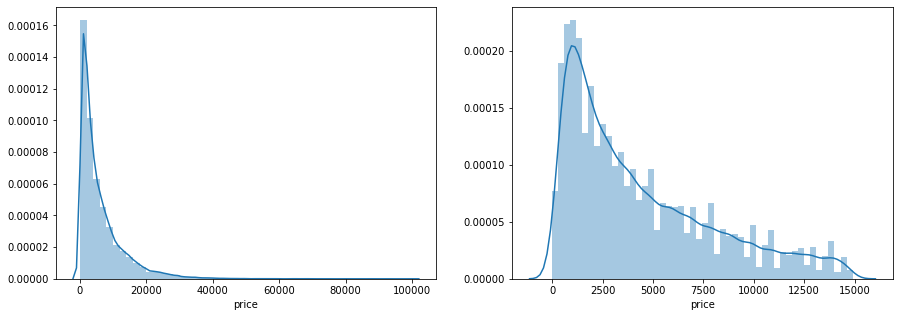

In [14]:
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

在这里我们对标签进行了  
l
o
g
(
x
+
1
)
  变换，使标签贴近于正态分布

In [15]:
train_y_ln = np.log(train_y + 1)

The transformed price seems like normal distribution


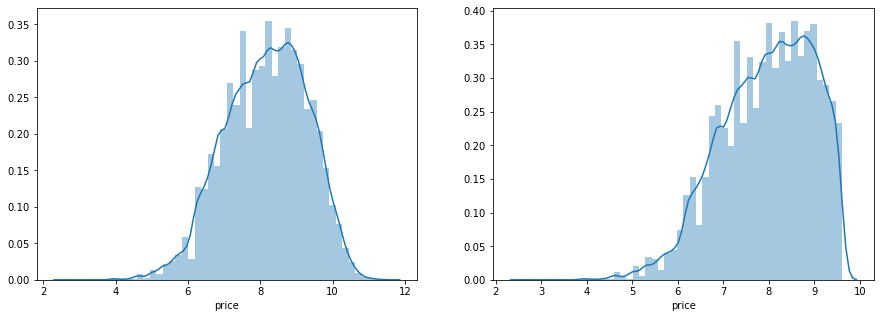

In [16]:
import seaborn as sns
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [17]:
model = model.fit(train_X, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:18.75074946562878


[('v_9', 8.052409900566696),
 ('v_5', 5.764236596649008),
 ('v_12', 1.618208123681179),
 ('v_1', 1.47983105829571),
 ('v_11', 1.1669016563632402),
 ('v_13', 0.9404711296035679),
 ('v_7', 0.7137273083558671),
 ('v_3', 0.68378757710919),
 ('v_0', 0.008500518010181613),
 ('power_bin', 0.008497969302894284),
 ('gearbox', 0.007922377278332254),
 ('fuelType', 0.006684769706827596),
 ('bodyType', 0.004523520092703736),
 ('power', 0.0007161894205356),
 ('brand_price_min', 3.334351114748945e-05),
 ('brand_amount', 2.8978797042774116e-06),
 ('brand_price_median', 1.2571172873021518e-06),
 ('brand_price_std', 6.659176363440789e-07),
 ('brand_price_max', 6.194956307515961e-07),
 ('brand_price_average', 5.999345965047678e-07),
 ('SaleID', 2.119417003964685e-08),
 ('train', -5.879030595679069e-11),
 ('offerType', -1.4210055354624274e-10),
 ('brand_price_sum', -1.5126504215922628e-10),
 ('seller', -1.709388186554861e-10),
 ('name', -7.015512588904125e-08),
 ('used_time', -4.122479372352062e-06),
 ('c

再可视化预测结果，改善程度较大

The predicted price seems normal after np.log transforming


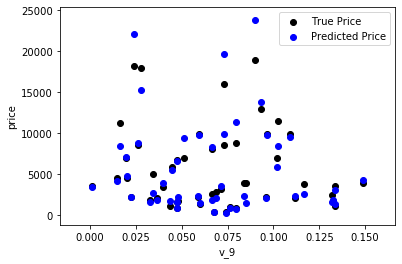

In [18]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

2、五折交叉验证

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

In [20]:
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

In [21]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished


使用线性回归模型，对未处理标签的特征数据进行五折交叉验证（Error 1.36）



In [22]:
print('AVG:', np.mean(scores))

AVG: 1.3658023920313886


使用线性回归模型，对处理过标签的特征数据进行五折交叉验证（Error 0.19）



In [23]:
scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished


In [24]:
print('AVG:', np.mean(scores))

AVG: 0.19325301837047446


In [25]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.190792,0.193758,0.194132,0.191825,0.195758


3、模拟实战

但在事实上，由于我们并不具有预知未来的能力，五折交叉验证在某些与时间相关的数据集上反而反映了不真实的情况。通过2018年的二手车价格预测2017年的二手车价格，这显然是不合理的，因此我们还可以采用时间顺序对数据集进行分隔。在本例中，我们选用靠前时间的4/5样本当作训练集，靠后时间的1/5当作验证集，最终结果与五折交叉验证差距不大



In [26]:
import datetime
sample_feature = sample_feature.reset_index(drop=True)
split_point = len(sample_feature) // 5 * 4

In [27]:
train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

train_X = train[continuous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_X = val[continuous_feature_names]
val_y_ln = np.log(val['price'] + 1)

In [28]:
model = model.fit(train_X, train_y_ln)
mean_absolute_error(val_y_ln, model.predict(val_X))

0.19577667270300944

4、绘制学习率和验证曲线

In [29]:
from sklearn.model_selection import learning_curve, validation_curve
? learning_curve


Signature:
 learning_curve(
    estimator,
    X,
    y,
    groups=None,
    train_sizes=array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
    cv=None,
    scoring=None,
    exploit_incremental_learning=False,
    n_jobs=1,
    pre_dispatch='all',
    verbose=0,
    shuffle=False,
    random_state=None,
)
Docstring:
Learning curve.

Determines cross-validated training and test scores for different training
set sizes.

A cross-validation generator splits the whole dataset k times in training
and test data. Subsets of the training set with varying sizes will be used
to train the estimator and a score for each training subset size and the
test set will be computed. Afterwards, the scores will be averaged over
all k runs for each training subset size.

Read more in the :ref:`User Guide <learning_curve>`.

Parameters
----------
estimator : object type that implements the "fit" and "predict" methods
    An object of that type which is cloned for each validation.

X : array-like, shape (n_samples,

In [30]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt  

<module 'matplotlib.pyplot' from 'f:\\python3.7\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

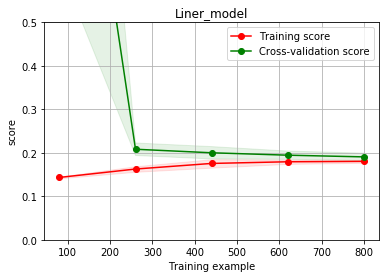

In [31]:
plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_y_ln[:1000], ylim=(0.0, 0.5), cv=5, n_jobs=1)  

### 4.4.3 多种模型对比

In [32]:
train = sample_feature[continuous_feature_names + ['price']].dropna()

train_X = train[continuous_feature_names]
train_y = train['price']
train_y_ln = np.log(train_y + 1)

1、线性模型与嵌入式特征选择

在过滤式和包裹式特征选择方法中，特征选择过程与学习器训练过程有明显的分别。而嵌入式特征选择在学习器训练过程中自动地进行特征选择。嵌入式选择最常用的是L1正则化与L2正则化。在对线性回归模型加入两种正则化方法后，他们分别变成了岭回归与Lasso回归。



In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [34]:
models = [LinearRegression(),
          Ridge(),
          Lasso()]

In [35]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
Ridge is finished
Lasso is finished


三种方法结果对比

In [37]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,Ridge,Lasso
cv1,0.190792,0.194832,0.383899
cv2,0.193758,0.197632,0.381893
cv3,0.194132,0.198123,0.384090
cv4,0.191825,0.195670,0.380526
cv5,0.195758,0.199676,0.383611


intercept:18.75074940557901


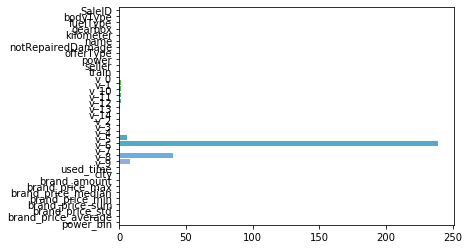

In [38]:
model = LinearRegression().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

L2正则化在拟合过程中通常都倾向于让权值尽可能小，最后构造一个所有参数都比较小的模型。因为一般认为参数值小的模型比较简单，能适应不同的数据集，也在一定程度上避免了过拟合现象。可以设想一下对于一个线性回归方程，若参数很大，那么只要数据偏移一点点，就会对结果造成很大的影响；但如果参数足够小，数据偏移得多一点也不会对结果造成什么影响，专业一点的说法是『抗扰动能力强』



intercept:4.671709787236445


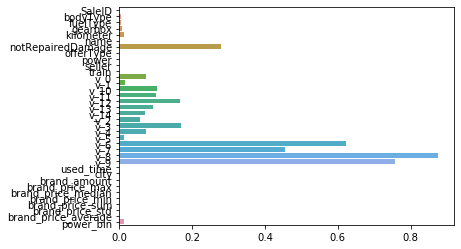

In [39]:
model = Ridge().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

L1正则化有助于生成一个稀疏权值矩阵，进而可以用于特征选择。如下图，我们发现power与userd_time特征非常重要。



intercept:8.672182402894254


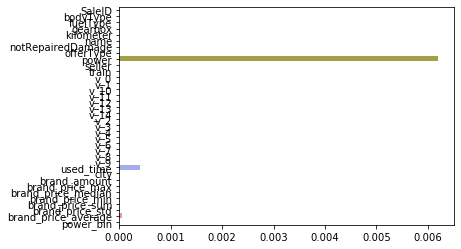

In [40]:
model = Lasso().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

除此之外，决策树通过信息熵或GINI指数选择分裂节点时，优先选择的分裂特征也更加重要，这同样是一种特征选择的方法。XGBoost与LightGBM模型中的model_importance指标正是基于此计算的



2、非线性模型

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

f:\python3.7\python37\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


ModuleNotFoundError: No module named 'xgboost'

In [ ]:
models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=100), 
          XGBRegressor(n_estimators = 100, objective='reg:squarederror'), 
          LGBMRegressor(n_estimators = 100)]

In [ ]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

In [ ]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

### 4.4.4 模型调参

In [ ]:
## LGB的参数集合：

objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']

num_leaves = [3,5,10,15,20,40, 55]
max_depth = [3,5,10,15,20,40, 55]
bagging_fraction = []
feature_fraction = []
drop_rate = []

1、贪心

In [ ]:
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score
    
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves] = score
    
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_depth[depth] = score

In [ ]:
sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'], y=[0.143 ,min(best_obj.values()), min(best_leaves.values()), min(best_depth.values())])

2、GridSearch

In [42]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = {'objective': objective , 'num_leaves': num_leaves, 'max_depth': max_depth}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(train_X, train_y)

In [ ]:
clf.best_params_

In [ ]:
model = LGBMRegressor(objective='regression',
                          num_leaves=55,
                          max_depth=15)

In [ ]:
np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))

3、贝叶斯

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
def rf_cv(num_leaves, max_depth, subsample, min_child_samples):
    val = cross_val_score(
        LGBMRegressor(objective = 'regression_l1',
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            subsample = subsample,
            min_child_samples = int(min_child_samples)
        ),
        X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)
    ).mean()
    return 1 - val

In [ ]:
rf_bo = BayesianOptimization(
    rf_cv,
    {
    'num_leaves': (2, 100),
    'max_depth': (2, 100),
    'subsample': (0.1, 1),
    'min_child_samples' : (2, 100)
    }
)

In [ ]:
rf_bo.maximize()

In [ ]:
1 - rf_bo.max['target']

在之前建模、调参和验证的基础上，采用一些基本办法继续提高精度

In [ ]:
plt.figure(figsize=(13,5))
sns.lineplot(x=['0_origin','1_log_transfer','2_L1_&_L2','3_change_model','4_parameter_turning'], y=[1.36 ,0.19, 0.19, 0.14, 0.13])